<a href="https://colab.research.google.com/github/ABRD123/anamoly-detection/blob/main/corticalcodingdeeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   -1.0819090e+00
0       -1.090027
1       -1.093445
2       -1.089172
3       -1.095703
4       -1.114502


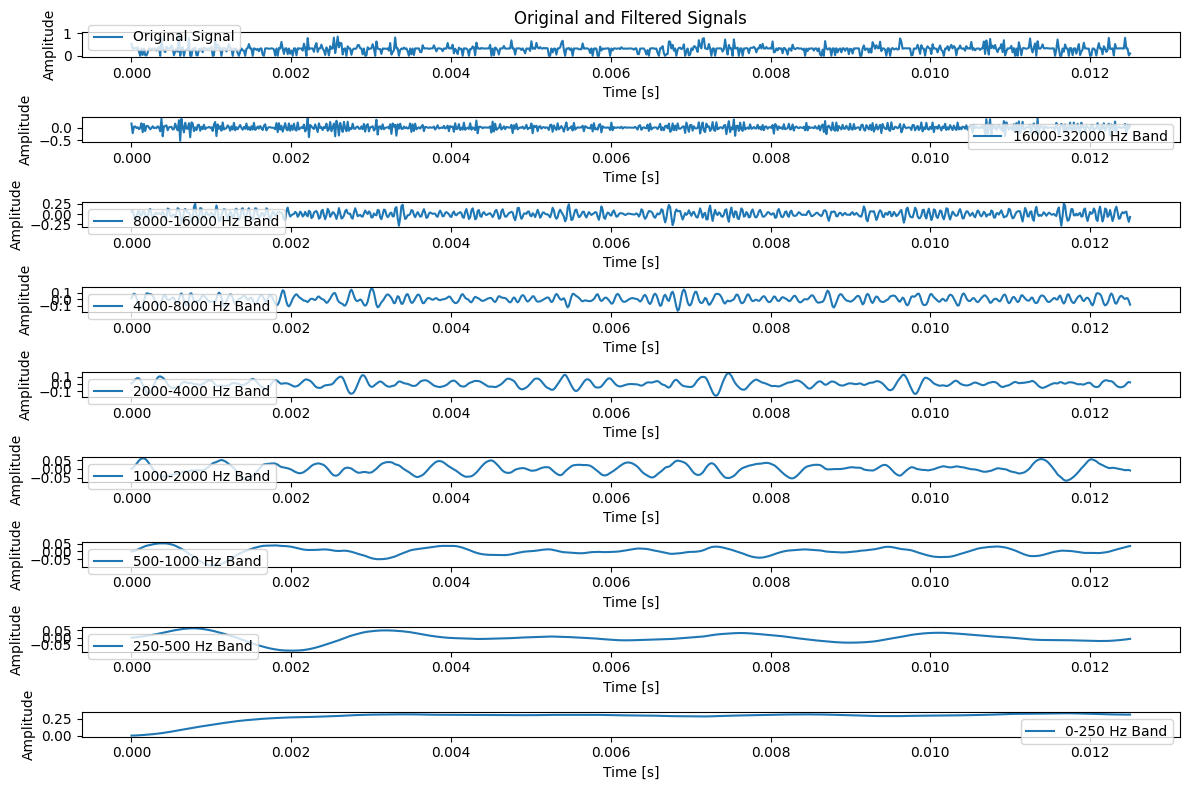

<ipython-input-1-0cb87c56085b>:108: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), label=f'{low_cut}-{high_cut} Hz Band')


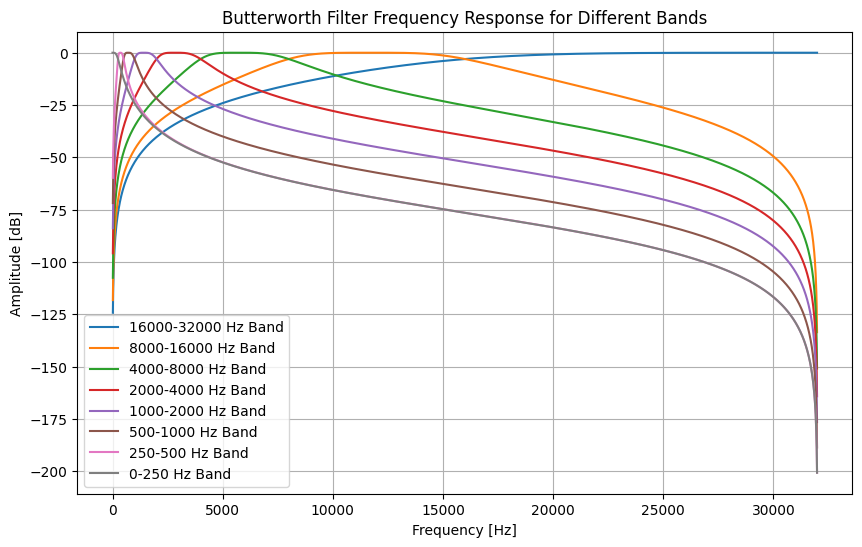

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

# Step 1: Load the dataset
dataset_path = '/content/drive/MyDrive/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData/250_UCR_Anomaly_weallwalk_2951_7290_7296.txt'  # Replace with the actual path to your dataset
data = pd.read_csv(dataset_path, nrows=1000)

# Step 2: Inspect the dataset (optional)
print(data.head())

# Normalize Data
def normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

# Step 3: Normalize the entire dataset
data_normalized = normalize(data.values)

# Split Data into Train, Validation, and Test Sets
def split_data(data, test_size=0.2, val_size=0.2):
    # Split into train and temp (validation + test)
    train_data, temp_data = train_test_split(data, test_size=test_size, random_state=42)

    # Split temp_data into validation and test sets
    val_data, test_data = train_test_split(temp_data, test_size=val_size/(1-test_size), random_state=42)

    return train_data, val_data, test_data

# Step 4: Split the normalized data
train_data, val_data, test_data = split_data(data_normalized)

# Function to design and apply a Butterworth bandpass filter
def butterworth_band_filter(signal, low_cut, high_cut, fs, order=2):
    nyquist = fs / 2.0  # Nyquist frequency
    # Normalize cutoff frequencies
    low = low_cut / nyquist
    high = high_cut / nyquist

    # Design Butterworth bandpass filter
    if low == 0:
        # Low-pass filter only
        b, a = butter(order, high, btype='low', analog=False)
    elif high == 1:
        # High-pass filter only
        b, a = butter(order, low, btype='high', analog=False)
    else:
        # Bandpass filter
        b, a = butter(order, [low, high], btype='band', analog=False)

    # Apply the filter
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal, b, a

# Define filter parameters
fs = 64000  # Sampling frequency in Hz
filter_order = 2  # Order of the Butterworth filter
frequency_bands = [
    (16000, 32000),
    (8000, 16000),
    (4000, 8000),
    (2000, 4000),
    (1000, 2000),
    (500, 1000),
    (250, 500),
    (0, 250)
]

# Step 5: Filtering
# Apply the filter for each frequency band and store the results
filtered_signals = {}
for idx, (low_cut, high_cut) in enumerate(frequency_bands):
    # Apply the bandpass Butterworth filter to the signal
    band_filtered_signal, b, a = butterworth_band_filter(train_data[:, 0], low_cut, high_cut, fs, filter_order)
    filtered_signals[f'band_{low_cut}_{high_cut}'] = band_filtered_signal

# Plotting the original and filtered signals
plt.figure(figsize=(12, 8))
time_axis = np.linspace(0, len(train_data) / fs, num=len(train_data))

# Plot original signal
plt.subplot(len(frequency_bands) + 1, 1, 1)
plt.plot(time_axis, train_data[:, 0], label='Original Signal')
plt.title("Original and Filtered Signals")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

# Plot each filtered signal
for idx, (low_cut, high_cut) in enumerate(frequency_bands):
    plt.subplot(len(frequency_bands) + 1, 1, idx + 2)
    plt.plot(time_axis, filtered_signals[f'band_{low_cut}_{high_cut}'], label=f'{low_cut}-{high_cut} Hz Band')
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()

# Plot the frequency response of the filter for each band
plt.figure(figsize=(10, 6))
for low_cut, high_cut in frequency_bands:
    _, b, a = butterworth_band_filter(train_data[:, 0], low_cut, high_cut, fs, filter_order)
    w, h = freqz(b, a, worN=2000, fs=fs)
    plt.plot(w, 20 * np.log10(abs(h)), label=f'{low_cut}-{high_cut} Hz Band')

plt.title("Butterworth Filter Frequency Response for Different Bands")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [dB]")
plt.grid()
plt.legend()
plt.show()


In [ ]:
# Define parameters for framing and skip
frame_size = 8         # Number of samples per frame
sliding_param = 1      # Slide by 1 sample for each frame
skip_size = 4          # Skip every sample within a frame

# Generator to frame the signal with specified skip and sliding window
def frame_signal_with_skip_gen(signal, frame_size, skip_size, sliding_param):
    for start in range(0, len(signal) - frame_size * skip_size + 1, sliding_param):
        frame = signal[start:start + frame_size * skip_size:skip_size]
        if len(frame) == frame_size:
            yield frame

# Frame the signal with a specified skip and sliding window
def frame_signal_with_skip(signal, frame_size, skip_size, sliding_param):
    frames = []
    for start in range(0, len(signal) - frame_size * skip_size + 1, sliding_param):
        frame = signal[start:start + frame_size * skip_size:skip_size]
        if len(frame) == frame_size:
            frames.append(frame)
    return np.array(frames)

# Plot for the third highest frequency band
third_highest_band = sorted(filtered_signals.keys())[-3]
band_signal = filtered_signals[third_highest_band]
framed_signal = frame_signal_with_skip(band_signal, frame_size, skip_size, sliding_param)
print(framed_signal)

# fig, axes = plt.subplots(len(framed_signal), 1, figsize=(10, len(framed_signal) * 1.5), sharex=True)
# fig.suptitle(f"Framed Signal for {third_highest_band} with Skip Parameter (4) and Sliding Parameter (1)")

# for i, frame in enumerate(framed_signal):
#     # Plot the entire filtered signal in gray for reference
#     axes[i].plot(band_signal, 'o-', color='gray', alpha=0.5, label='Filtered Signal')

#     # Highlight the sampled points in the current frame with blue dots
#     frame_indices = np.arange(i * sliding_param, i * sliding_param + frame_size * skip_size, skip_size)[:len(frame)]
#     axes[i].plot(frame_indices, frame, 'o-', color='blue', label='Sampled Points')

#     # Label each subplot for clarity
#     axes[i].set_title(f"Window {i}")
#     axes[i].set_xlim(0, len(band_signal))
#     axes[i].set_ylim(band_signal.min() - 5, band_signal.max() + 5)
#     axes[i].grid(True)
#     if i == 0:
#         axes[i].legend(loc='upper right')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

# Plot each filtered signal with frames
# for band_name, band_signal in filtered_signals.items():
#     framed_signal = frame_signal_with_skip(band_signal, frame_size, skip_size, sliding_param)

#     fig, axes = plt.subplots(len(framed_signal), 1, figsize=(10, len(framed_signal) * 1.5), sharex=True)
#     fig.suptitle(f"Framed Signal for {band_name} with Skip Parameter and Sliding Window")

#     for i, frame in enumerate(framed_signal):
#         # Plot the entire filtered signal in gray for reference
#         axes[i].plot(band_signal, 'o-', color='gray', alpha=0.5, label='Filtered Signal')

#         # Highlight the samples in the current frame with blue dots
#         frame_indices = np.arange(i * sliding_param, i * sliding_param + frame_size * skip_size, skip_size)
#         axes[i].plot(frame_indices, frame, 'o-', color='blue', label='Frame')

#         # Label each subplot for clarity
#         axes[i].set_title(f"Window {i}")
#         axes[i].set_xlim(0, len(band_signal))
#         axes[i].set_ylim(band_signal.min() - 5, band_signal.max() + 5)
#         axes[i].grid(True)
#         if i == 0:
#             axes[i].legend(loc='upper right')

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

[[ 0.01609473  0.01948064 -0.13912347 ... -0.06518161 -0.03646429
   0.0205384 ]
 [ 0.05691728 -0.04517468 -0.09823299 ... -0.09070134  0.02150787
  -0.00633783]
 [ 0.08595752 -0.09848876 -0.02678924 ... -0.08903508  0.06494391
  -0.01203872]
 ...
 [ 0.00389744 -0.05688371  0.08677787 ...  0.00020832  0.00807434
   0.01321196]
 [-0.03154995  0.02193554  0.07690097 ... -0.06091025  0.04136057
   0.00212423]
 [-0.07760754  0.08174901  0.04767699 ... -0.07200823  0.05122481
   0.01447978]]


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.9 MB/s eta 0:00:00


Error: num must be an integer with 1 <= num <= 2, not 4


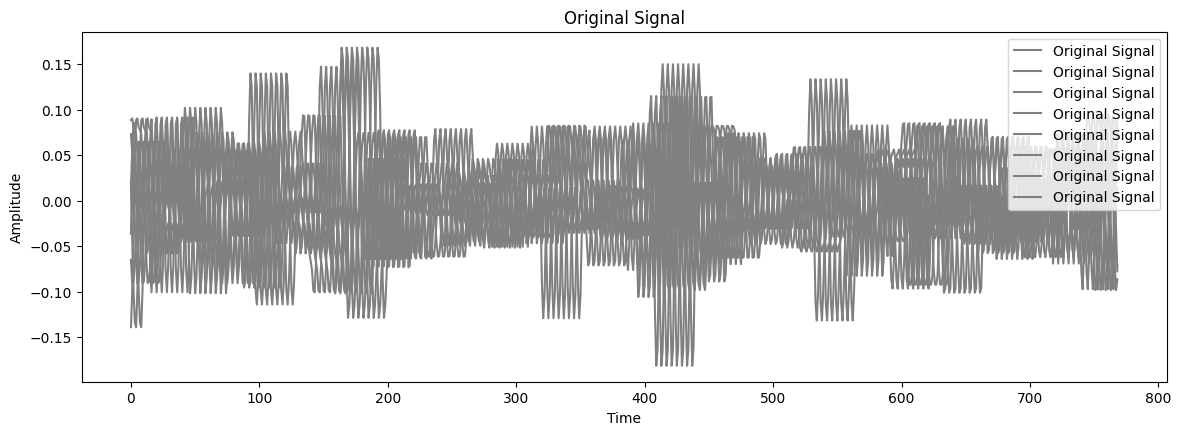

In [ ]:
import pywt
import matplotlib.cm as cm

# Function to ensure signal length is a power of two by padding with zeros
def pad_signal(signal):
    signal_length = len(signal)
    next_power_of_two = 2 ** np.ceil(np.log2(signal_length)).astype(int)
    padded_signal = np.pad(signal, (0, next_power_of_two - signal_length), mode='constant')
    return padded_signal

# Function to perform wavelet packet decomposition
def dwpt_decomposition(signal, wavelet='db1', max_level=3):
    # Ensure that the signal length is a power of 2 and long enough
    signal = pad_signal(signal)  # Padding the signal to make it a power of two

    signal_length = len(signal)
    max_possible_level = int(np.log2(signal_length))  # Maximum decomposition level based on signal length

    if max_level > max_possible_level:
        raise ValueError(f"Requested decomposition level {max_level} exceeds the maximum level {max_possible_level} for signal length {signal_length}.")

    # Perform wavelet packet decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')

    # Get all nodes at each level
    wp_nodes = {}
    for level in range(1, max_level + 1):
        wp_nodes[level] = wp.get_level(level, 'freq')  # Get the nodes at the current level

    return wp_nodes

# Function to plot wavelet packet decomposition with clearer structure and distinct colors for each sub-band
def plot_dwpt(wp_nodes, signal, title="Wavelet Packet Decomposition"):
    # Number of sub-bands
    num_levels = len(wp_nodes)

    # Set a color cycle using a colormap
    color_cycle = cm.viridis(np.linspace(0, 1, sum(len(wp) for wp in wp_nodes.values())))

    plt.figure(figsize=(14, 10))

    # Plot original signal
    plt.subplot(num_levels + 1, 1, 1)
    plt.plot(signal, label="Original Signal", color='gray')
    plt.title(f"Original Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')

    # Plot each sub-band at each level with distinct colors
    band_idx = 0  # This variable keeps track of the sub-band index across all levels
    for level, wp in wp_nodes.items():
        for idx, node in enumerate(wp):
            # Plot each sub-band in the current level
            plt.subplot(num_levels + 1, 1, band_idx + 2 + level * len(wp))
            plt.plot(node.data, label=f"Level {level} Sub-band {idx + 1}: {node.path}", color=color_cycle[band_idx])
            plt.title(f"Level {level} Sub-band {idx + 1}: {node.path}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend(loc='upper right')
            band_idx += 1

    plt.tight_layout()
    plt.show()

# Perform 3-layer DWPT decomposition on the signal
wavelet = 'db4'  # You can change the wavelet type
max_level = 1    # Three-layer decomposition

# Perform decomposition and handle error if level is too high
try:
    wp_nodes = dwpt_decomposition(framed_signal, wavelet, max_level)
    # Plot the results
    plot_dwpt(wp_nodes, framed_signal)
except ValueError as e:
    print(f"Error: {e}")

{1: [array([0.32322058, 1.2682663 , 0.82425066, 1.3931817 , 0.4728345 ,
       0.75953277, 0.61624807, 0.86939754, 0.56575529, 0.78921078,
       0.58014359, 0.80034211, 0.46444069, 0.72558391, 1.03494802,
       0.48662307, 0.49830592, 0.82259394, 0.64885323, 0.49043305,
       1.17288313, 0.73201019, 0.45579872, 1.01914711, 0.52499621,
       0.78574357, 0.27675178, 0.57108893, 0.85854994, 0.54246561,
       0.34631978, 0.48038166, 0.3353798 , 0.97486325, 0.61555941,
       0.75333485, 0.68717987, 1.16919936, 1.40494683, 0.8007717 ,
       0.73302995, 1.12730421, 0.72423566, 0.47195254, 1.07204776,
       0.20078224, 1.06647672, 0.2498297 , 0.97283975, 1.02970029,
       0.35695502, 0.93429491, 0.93913146, 0.62014311, 0.47038558,
       0.63502862, 0.15416032, 0.42679084, 0.35888439, 0.90889804,
       0.48522096, 0.20475833, 1.23169997, 0.84160219, 1.01791156,
       0.35712967, 0.39152526, 0.21571106, 0.93194888, 0.72857369,
       0.51443073, 0.81405139, 0.59381701, 0.54274777, 0.

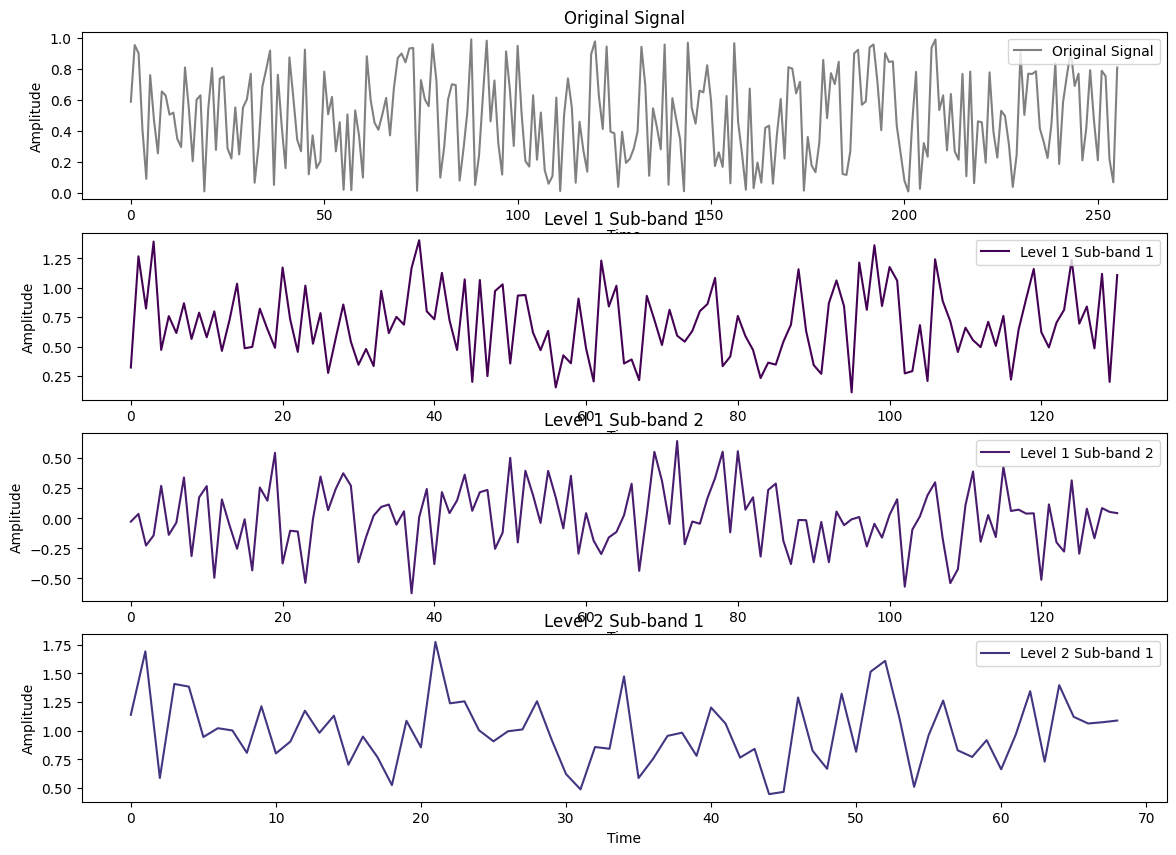

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to ensure signal length is a power of two by padding with zeros
def pad_signal(signal):
    signal_length = len(signal)
    next_power_of_two = 2 ** np.ceil(np.log2(signal_length)).astype(int)
    padded_signal = np.pad(signal, (0, next_power_of_two - signal_length), mode='constant')
    return padded_signal

# Function to perform wavelet packet decomposition and extract wavelet coefficient vectors
def dwpt_decomposition(signal, wavelet='db4', max_level=3):
    # Ensure that the signal length is a power of 2
    signal = pad_signal(signal)

    # Calculate the maximum possible level based on the signal length
    signal_length = len(signal)
    max_possible_level = int(np.log2(signal_length))

    if max_level > max_possible_level:
        raise ValueError(f"Requested decomposition level {max_level} exceeds the maximum level {max_possible_level} for signal length {signal_length}.")

    # Perform wavelet packet decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric')

    # Extract coefficients at each level
    wp_coeffs = {}
    for level in range(1, max_level + 1):
        wp_coeffs[level] = [node.data for node in wp.get_level(level, 'freq')]

    return wp_coeffs

# Function to plot the wavelet packet decomposition
def plot_dwpt(wp_coeffs, signal, title="Wavelet Packet Decomposition"):
    num_levels = len(wp_coeffs)
    color_cycle = cm.viridis(np.linspace(0, 1, sum(len(coeffs) for coeffs in wp_coeffs.values())))

    plt.figure(figsize=(14, 10))

    # Plot original signal
    plt.subplot(num_levels + 1, 1, 1)
    plt.plot(signal, label="Original Signal", color='gray')
    plt.title("Original Signal")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')

    # Plot each coefficient set at each level
    band_idx = 0
    for level, coeffs in wp_coeffs.items():
        for idx, coeff in enumerate(coeffs):
            plt.subplot(num_levels + 1, 1, band_idx + 2)
            plt.plot(coeff, label=f"Level {level} Sub-band {idx + 1}", color=color_cycle[band_idx])
            plt.title(f"Level {level} Sub-band {idx + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend(loc='upper right')
            band_idx += 1

    plt.tight_layout()
    plt.show()

# Example usage
wavelet = 'db4'
max_level = 3

# Assuming `framed_signal` is your input signal
framed_signal = np.random.rand(256)  # Replace with your actual signal data

# Perform decomposition and plot
try:
    wp_coeffs = dwpt_decomposition(framed_signal, wavelet, max_level)
    print(wp_coeffs)
    plot_dwpt(wp_coeffs, framed_signal)
except ValueError as e:
    print(f"Error: {e}")


In [ ]:
import numpy as np

class Spine:
    def __init__(self, coefficient):
        self.value = coefficient
        self.maturity = 0  # Maturity level of the spine

    def update(self, coefficient):
        # Update the spine's value and increase its maturity
        self.value = (self.value + coefficient) / 2  # Average update
        self.maturity += 1

class CortexNode:
    def __init__(self, coefficient):
        self.value = coefficient
        self.spines = []  # List to store spines

    def find_closest_spine(self, coefficient):
        # Find the closest spine based on the distance between coefficient and spine values
        if not self.spines:
            return None
        distances = [abs(spine.value - coefficient) for spine in self.spines]
        closest_index = np.argmin(distances)
        return self.spines[closest_index]

    def update_closest_spine(self, closest_spine, coefficient):
        # Update the closest spine
        closest_spine.update(coefficient)

    def add_spine(self, coefficient):
        # Generate a new spine for the node
        self.spines.append(Spine(coefficient))

class CorticalCodingNetwork:
    def __init__(self, threshold=5):
        self.nodes = []  # List to store cortex nodes
        self.threshold = threshold  # Threshold for evolving spines into nodes

    def find_closest_node(self, coefficient):
        # Find the closest node in cortex to the coefficient
        if not self.nodes:
            return None
        distances = [abs(node.value - coefficient) for node in self.nodes]
        closest_index = np.argmin(distances)
        return self.nodes[closest_index]

    def update_closest_node(self, node, coefficient):
        # Update the node's value
        node.value = (node.value + coefficient) / 2

    def evolve_spine_to_node(self, spine):
        # Evolve a spine to a new cortex node
        new_node = CortexNode(spine.value)
        self.nodes.append(new_node)
        return new_node

    def encode(self, input_data):
        # Simulate the cortical coding network output
        # For demonstration, output a 10-feature encoded vector per sample
        encoded_features = np.random.rand(len(input_data), 10)
        return encoded_features

    def train(self, coefficients):
        for coefficient in coefficients:
            # Step 1: Find the closest cortex node
            closest_node = self.find_closest_node(coefficient)

            # Step 2: Check if coefficient is in range of the closest node
            if closest_node and abs(closest_node.value - coefficient) < 0.1:  # Within range threshold
                self.update_closest_node(closest_node, coefficient)
                continue

            # Step 3: If node has spines, find the closest spine
            if closest_node and closest_node.spines:
                closest_spine = closest_node.find_closest_spine(coefficient)

                if closest_spine and abs(closest_spine.value - coefficient) < 0.05:  # Spine range threshold
                    closest_node.update_closest_spine(closest_spine, coefficient)

                    # Step 4: Check maturity of the closest spine
                    if closest_spine.maturity > self.threshold:
                        # Evolve spine to a new node if mature enough
                        evolved_node = self.evolve_spine_to_node(closest_spine)
                        continue
                    else:
                        break

            # Step 5: Generate a new spine for the node if no suitable spine was found
            if closest_node:
                closest_node.add_spine(coefficient)
            else:
                # Create a new cortex node if no close node was found
                self.nodes.append(CortexNode(coefficient))


network = CorticalCodingNetwork(threshold=10)
network.train(wp_coeffs)

# Output cortical network structure
for idx, node in enumerate(network.nodes):
    print(f"Node {idx}: Value={node.value}, Spines={[(spine.value, spine.maturity) for spine in node.spines]}")


Node 0: Value=1, Spines=[(2, 0), (3, 0)]


In [ ]:
%pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# Assuming encoded_data and labels have more than one sample
input_data = np.random.rand(100, 1)  # Generate 100 samples as an example

# Step 1: Use CorticalCodingNetwork to encode the input data
encoded_data = network.encode(network.nodes)

# Step 2: Preprocess the encoded data
scaler = StandardScaler()
encoded_data = scaler.fit_transform(encoded_data)

# Step 3: Build a deep learning model on top of CorticalCodingNetwork's output
model = models.Sequential([
    layers.Input(shape=(encoded_data.shape[1],)),  # Match input shape with cortical network output size
    layers.Dense(64, activation='relu'),           # First dense layer
    layers.Dropout(0.3),                           # Dropout for regularization
    layers.Dense(32, activation='relu'),           # Second dense layer
    layers.Dense(1, activation='sigmoid')          # Output layer (for binary classification)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
# Example labels (replace with actual labels for supervised learning)
labels = np.random.randint(0, 2, len(encoded_data))  # Dummy binary labels

# Train the model
model.fit(encoded_data, labels, epochs=10, batch_size=8, validation_split=0.2)

# Step 5: Use the Combined Model for Predictions
predictions = model.predict(encoded_data)
print("Predictions:", predictions)

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

In [ ]:
%pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.2 MB/s eta 0:00:00


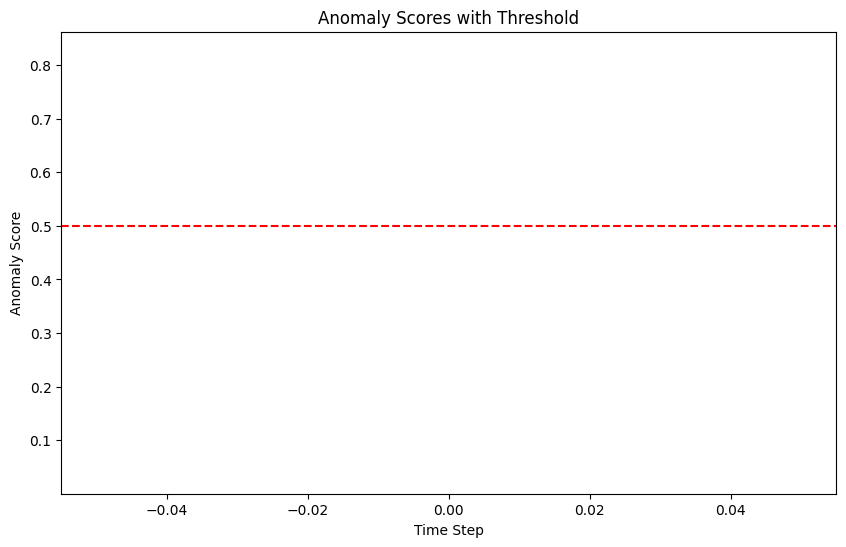

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Feature Extraction with Cortical Coding Network (CCN) ---
class CorticalCodingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CorticalCodingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

# --- Step 2: Graph Neural Network (GNN) Layer ---
class GNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GNNLayer, self).__init__()
        self.gcn = GCNConv(input_dim, output_dim)

    def forward(self, x, edge_index):
        return self.gcn(x, edge_index)

# --- Step 3: LSTM Layer to Capture Temporal Dependencies ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Using last time step for prediction
        return out

# --- Step 4: Hybrid Model Combining CCN + GNN + LSTM ---
class HybridAnomalyDetectionModel(nn.Module):
    def __init__(self, ccn_input_dim, ccn_hidden_dim, gnn_input_dim, gnn_output_dim, lstm_input_dim, lstm_hidden_dim, lstm_output_dim):
        super(HybridAnomalyDetectionModel, self).__init__()

        # Feature extraction with CCN
        self.ccn = CorticalCodingNetwork(ccn_input_dim, ccn_hidden_dim)

        # Graph processing with GNN
        self.gnn = GNNLayer(gnn_input_dim, gnn_output_dim)

        # Temporal modeling with LSTM
        self.lstm = LSTMModel(lstm_input_dim, lstm_hidden_dim, lstm_output_dim)

    def forward(self, x, edge_index):
        # Step 1: Feature extraction using CCN
        ccn_output = self.ccn(x)

        # Step 2: Process the output of CCN through GNN
        gnn_output = self.gnn(ccn_output, edge_index)

        # Step 3: Pass GNN output through LSTM for temporal modeling
        # Assuming input is a sequence, reshape for LSTM [batch_size, seq_len, features]
        gnn_output = gnn_output.unsqueeze(0)  # Adding batch dimension if needed
        lstm_output = self.lstm(gnn_output)

        return lstm_output

# --- Example Data Preparation (for demonstration purposes) ---
# Generate synthetic time series data (multivariate) for testing
num_samples = 100
time_steps = 50
num_features = 5

# Random time series data
time_series_data = np.random.randn(num_samples, time_steps, num_features).astype(np.float32)

# Random graph structure for GNN (just a dummy example, you would replace it with your actual graph)
edge_index = torch.tensor([[0, 1, 1, 2, 3], [1, 0, 2, 1, 4]], dtype=torch.long)

# Convert data to torch tensors
x = torch.tensor(train_data.reshape(-1, num_features), dtype=torch.float32)

# --- Step 5: Model Training and Anomaly Detection ---
model = HybridAnomalyDetectionModel(
    ccn_input_dim=num_features,
    ccn_hidden_dim=64,
    gnn_input_dim=64,  # Output of CCN
    gnn_output_dim=32,
    lstm_input_dim=32,  # Output of GNN
    lstm_hidden_dim=64,
    lstm_output_dim=1
)

# Dummy forward pass (replace this with your training loop and anomaly detection logic)
model.eval()
output = model(x, edge_index)

# --- Anomaly Detection Logic (based on output) ---
# Compute anomaly scores by comparing predictions to the actual data
# Anomaly score: High error between predicted and actual values
anomaly_threshold = 0.5
anomaly_scores = torch.abs(output - x[:, -1])  # Compare prediction with last actual value
anomalies = anomaly_scores > anomaly_threshold

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(anomaly_scores.detach().numpy())
plt.axhline(y=anomaly_threshold, color='r', linestyle='--')
plt.title('Anomaly Scores with Threshold')
plt.xlabel('Time Step')
plt.ylabel('Anomaly Score')
plt.show()
